**<div align='center' ><font size='5'> Modelling algal bloom in Lake Erie based on python, a case study in Lake Erie</font></div>**

# Abstract
Lake algal blooms are the major environmental issues in the world. To help on algal bloom management, a numerical model based on Python3 was developed to simulate the mean chl-a variation in a lake ecosystem. The model took the tributary loading, nutrient limitation, temperature and light effects on algal growth, uptake and death into consideration and quantified them with time based ordinary system equation systems. To test the mode ability, I built and validated the model with the nutrients, chl-a, hydrodynamic and meteorological data from Lake Erie to simulate the chl-a variation in the algal bloom season in 2018 (May to Oct). The bias of the model was significant (Nash–Sutcliffe Efficiency coefficient of the chl-a was -4.44)., but the model outputs showed a similar variation pattern with the trend of the observed results. To make the model better, I proposed several thoughts on finding reliable validation data source and calibration techniques. Generally speaking, the model still has large room for improvement and requires continuing study to make the model more realistic.

**Key words: Lake algal bloom, numerical model, Python3, Lake Erie**

# Introduction
Algal bloom is one of the global environmental issues due to its negative effects on ecosystem and human society (Glibert et al., 2018; McLean and Sinclair, 2012). The excessive algal growth, especially the Microcystis spp. in the cyanobacterial community, can produce toxins which are detrimental for animals’ health, including human. For instance, the cyanobacterial algal bloom in Lake Erie, America. In August 2014, the water supply to 600,000 people in Toledo was shut down for two days from Lake Erie (Steffen et al., 2017). The bloom events were frequently found on the shallow lakes in tropic and temperate regions where the flow disturbance is weak (Huang et al., 2016) and the light, temperature is optimal for algal growth (Tian-jiu, 2015). It is believed that nutrients (nitrogen, phosphorus) from fertilizers and the wastewater are the main factors contributing to the algal blooms (Paerl, 2017). Other than that, global warming was also proposed to be responsible for increasing algal bloom on a global scale (Paul, 2008). 

It is essential to manage and control the algal blooms in the lake. By using the data of the algal bloom stressors: nutrients, temperature, light, zooplankton (Chouvelon et al., 2019), sediment and other physiochemical parameters, many researchers build various numerical models to simulate the variation of the algal biomass (mostly indicated by chlorophyll-a). Many fantastic software showed good performances in the real environmental management studies, such as EFDC (Environmental Fluid Dynamic Code), Delft3D, DHI Mike (Maintained by Danish Hydraulic Institute). For example, (Kim et al., 2017) applied EFDC to build an algal bloom forecasting model at the lower Han River, Korea, which showed a good performance comparing with the monitoring data collected from 2013 to 2015. However, most of them are business software with expensive price. Moreover, source codes of the free algal bloom models were mostly written in Fortran or Microsoft C++, which are cryptic to read and configure.

In this context, we designed a lake algal bloom model based on Python3 (SciPy, NumPy, Pandas needed to be installed), in which nutrients limitation, temperature effects and light intensity to control the algal growth. More importantly, the model only requires discharge, Total Kjeldahl Nitrogen (TKN), Total Phosphorus (TP), temperature and light intensity data to support the model building. We apply the model on the Lake Erie to model the chl-a variation in 2018 algal bloom season (May-Oct). Because it is a prototype of a lake algal bloom model, there remains a large space to make the model more ‘real’. The source code will be uploaded on my GitHub and GitLab repository, welcome to add your thoughts and contribute to the model.

# Methods and Materials

## Research Area
Lake Erie is the fourth-largest lake (by surface area) of the five Great Lakes in North America. The northern part belongs to Canada and the southern part locates in the United States. According to the description from the United States Environmental Protection Agency (EPA) (https://www.epa.gov/greatlakes/lake-erie#about), the surface area of the lake is around 25,874km2 , and the average volume is 480km2. The increasing nutrients loading from the fertilizer, wastewater and tributaries caused increasing algal bloom occurrence in the lake. The main flow direction is from west to east. The main inflow tributaries of the Lake Erie are the Detroit River, which connects the Lake Huron and the Lake Erie. The Maumee River, Sandusky River, Portage River and Huron River also played an important role in nutrients loading to the lake (Maccoux et al., 2016). The main outflow tributary is the Niagara River. From Fig.1, It is clear to observe that the algal bloom often occurs in western part, whereas it does not happen frequently the central and the eastern lake. Which attributes to the water depth in western area is shallower than the other area.

![jupyter](./Fig1.png)
<center style="font-size:8px;text-decoration">Fig.1 Lake Erie. (a) MODIS True color image of the Lake Erie image taken on 07/01/2018. (b) Water Depth contour map of the Lake Erie. (c) The location of the Lake Erie Monitoring stations (https://www.glerl.noaa.gov/res/HABs_and_Hypoxia/wle-weekly-current/ )</center> 

## Data Preparation: Loading, Temperature, Light

The data we used in this paper contained two parts: Tributary discharge and water quality data, physical parameters from the stations in the lake (water quality, water temperature, light intensity, water levels). The discharge of the of the main tributaries we used were from National water Inventory System (NWIS), maintained by U.S. Geological Survey (USGS) (https://waterdata.usgs.gov/nwis). The water quality data of the tributaries were from the National Center for Water Quality Research, maintained by Heidelberg University (https://ncwqr.org/monitoring/data/). The monitoring data in the lake region were from the NOAA National Centers for Environmental Information, provided by Cooperative Institute for Great Lakes Research, University of Michigan and NOAA Great Lakes Environmental Research Laboratory. 

Because the record chl-a monitoring data of the tributaries is unavailable, we used the lake monitoring data to represent the inflow or outflow chl-a concentration. Because our model time step is 1 day, we use second order polynomial interpolation to create daily series by using monthly or weekly sampling data.

In [1]:
# Import Packages
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Define a function to select & interpolate tributary flow and water quality data

In [2]:
def redate(Cuyahoga_origin):
    # Trnasform the datetime col to daily
    Cuyahoga_origin['Datetime (date and time of sample collection)'] = pd.to_datetime(Cuyahoga_origin['Datetime (date and time of sample collection)'])
    Cuyahoga_origin['Datetime (date and time of sample collection)'] = Cuyahoga_origin['Datetime (date and time of sample collection)'].dt.date
    # Gourp each day, 
    Cuyahoga_origin = Cuyahoga_origin.groupby(Cuyahoga_origin['Datetime (date and time of sample collection)']).mean()
    # Select 2018 data
    daterange = pd.date_range('2018-05-01', '2018-10-01')
    Cuyahoga_origin = Cuyahoga_origin.reindex(daterange)
    Cuyahoga_origin = Cuyahoga_origin.iloc[:,[2,4,7]]
    Cuyahoga_origin.columns = ['Flow','TP','TKN']
    Cuyahoga_origin['Flow'] = Cuyahoga_origin['Flow'] * 0.3048 ** 3 * 24 * 3600# Transform into m3/d
    return Cuyahoga_origin

In [3]:
## read tributary data
Cuyahoga_origin = redate(pd.read_csv('Tributary data/cuyahoga data.csv'))
Maumee_origin = redate(pd.read_csv('Tributary data/maumeedata.csv'))
Portage_origin = redate(pd.read_csv('Tributary data/portagedata.csv'))
Sandusky_origin = redate(pd.read_csv('Tributary data/sanduskydata.csv'))

## Process the tributary data for analysis
Cuyahoga_origin.loc['2018-10-01'] = [1000* 0.3048 ** 3 * 24 * 3600, 0.11, 0.74]
Cuyahoga = Cuyahoga_origin.interpolate(method='polynomial', order = 2)
Maumee = Maumee_origin.interpolate(method='polynomial', order = 2)
Portage = Portage_origin.interpolate(method='polynomial', order = 2)
Sandusky = Sandusky_origin.interpolate(method='polynomial', order = 2)
Cuyahoga

,Flow,TP,TKN
2018-05-01,1.844718e+06,0.055000,0.773000
2018-05-02,1.457670e+06,0.049000,0.699000
2018-05-03,2.318008e+06,0.145000,0.667000
2018-05-04,2.833134e+06,0.089000,0.504500
2018-05-05,2.290239e+06,0.064000,0.705000
...,...,...,...
2018-09-27,4.868824e+05,0.054663,0.670238
2018-09-28,8.043379e+05,0.062919,0.680321
2018-09-29,1.236772e+06,0.074894,0.695309
2018-09-30,1.784184e+06,0.090588,0.715202


- Preprocess the main tributary from NWIS

In [4]:
Main = pd.read_csv('Tributary data/Main Discharge.csv', index_col = 0, parse_dates = True)
Detroit = Main.loc[pd.date_range('2018-05-01', '2018-10-01'),['Detroit']] * 24 * 3600
Nigara = Main.loc[pd.date_range('2018-05-01', '2018-10-01'),['Nigara']] * 24 * 3600
Detroit['TP'] = Maumee['TP']
Detroit['TKN'] = Maumee['TKN']
Nigara['TP'] = Cuyahoga['TP']
Nigara['TKN'] = Cuyahoga['TKN']
Detroit.columns = ['Flow','TP','TKN']
Nigara.columns = ['Flow','TP','TKN']
Detroit.head()

,Flow,TP,TKN
2018-05-01,5.858487e+08,0.112000,1.335
2018-05-02,5.821680e+08,0.110000,1.386
2018-05-03,5.778326e+08,0.682000,2.438
2018-05-04,5.737869e+08,0.570333,2.107
2018-05-05,5.701884e+08,0.384000,1.776


- Read Lake Water Quality data to get Light and Temperature Series

In [5]:
lakewq = pd.read_csv('lakeWQ2018.csv', index_col=0, parse_dates=True)
# Aquire the average tem and light intensity of the lake erie
WatTem = lakewq.groupby(lakewq.index).mean().loc[:,['Temperature']]
Light = lakewq.groupby(lakewq.index).mean().loc[:,['Light Intensity']]
WatTem = WatTem.reindex(pd.date_range('2018-05-01', '2018-10-01'))
WatTem.loc['2018-05-01'] = 17.1
WatTem.loc['2018-10-01'] = 19.1
WatTem = WatTem.interpolate(method='polynomial', order = 2)
Light = Light.reindex(pd.date_range('2018-05-01', '2018-10-01'))
Light.loc['2018-05-01'] = 100
Light.loc['2018-10-01'] = 334.125
Light = Light.interpolate(method='polynomial', order = 2)
WatTem.head()

,Temperature
2018-05-01,17.100000
2018-05-02,17.038266
2018-05-03,16.985399
2018-05-04,16.941399
2018-05-05,16.906265


- Assign chl-a for each tributaries by lake monitoring data

In [6]:
def get_chl(WE):# Input the site number
    chl = lakewq.loc[lakewq.loc[:,'Site'] == WE]
    chl = chl.reindex(pd.date_range('2018-05-01', '2018-10-01'))
    chl.loc['2018-05-01'] = 12
    chl = chl.interpolate(method='polynomial', order = 2)
    return chl['chl-a']

In [7]:
# Trnasform into mg/L
Detroit['chla'] = get_chl('WE6') * 0.001
Maumee['chla'] = get_chl('WE6') * 0.001
Portage['chla'] = get_chl('WE16') * 0.001
Sandusky['chla'] = get_chl('WE2') * 0.001
Cuyahoga['chla'] = get_chl('WE13') * 0.001
Nigara['chla'] = get_chl('WE8') * 0.001

- Loading Calculation: Get W_tkn, W_tp, W_chla

In [8]:
def cal_loading(WQ): #input the parameter name,'TP','TKN','chla'
    W_in = 0
    for inflow in [Detroit, Maumee, Portage, Sandusky, Cuyahoga]:
        W_in = inflow['Flow'] * inflow[WQ] + W_in
    W_out = Nigara['Flow'] * Nigara[WQ]
    W = W_in * 2 - W_out
    return W

In [9]:
W_tkn = cal_loading('TKN')
W_tp = cal_loading('TP')
W_chla = cal_loading('chla')

## Model Conceptualization

### Volume Variation

\begin{equation}
    V_{\left(t\right)}=\frac{V_{mean}}{H_{mean}}H_t+b=2.7484\times{10}^9\times H_t+b
\end{equation}

$V_{\left(t\right)}$, $m^3$, is the volume of the Lake Erie at t (time/date). $H_t$, $meter (IGLD85)$, denotes the water level observation value in Lake Erie. b, m3, is the correction item for approximating the volume, here we set it as 0 for simplicity. $V_{mean}$ is the mean storage of the Lake Erie, $H_{mean}$ is the mean water level in Lake Erie. Both mean values are from the EPA description page (https://www.epa.gov/greatlakes/lake-erie). 

We assume that the surface area of the lake is constant and the water level variation has a robust positive relationship to the volume. According to EPA, the average of the volume is $ 480km^2 $  and our water level average is 174.64 m. So the coefficient transformed from water level to the volume was set as $2.7484\times 10^9 m^2$.

### Nutrient Balance

\begin{eqnarray}
 S_{N(t)} = \frac{d_N}{d_t}\ = \frac{ \sum_i^nI_ic_{Ni}\ - \sum_j^mQ_ic_{Nj}\ }{V_{t}}\ - d_N \cdot\ c_{N(t)} - Upt_{N}\cdot\ c_{N(t)} \\
 S_{P(t)} = \frac{d_P}{d_t}\ = \frac{\sum_i^nI_ic_{Pi}\ - \sum_j^mQ_ic_{Pj}\ }{V_{t}} - d_P \cdot\ c_{P} - Upt_{P} \cdot\ c_{P}
 \end{eqnarray}
 
The nitrogen/Phosphorus concentration in the Lake is influenced by tributary loading, natural losing(settle, other chemical reactions), uptake by phytoplankton. $S_{N(t)}$ is the change rate of Nitrogen at time t. $I_{i}$ is the inflow discharge of tributary i, $c_Ni$ is the N concentration of the inflow tributary i. $Q_{j}$ is the outflow discharge of tributary j. $c_N$ is the mean N concentration in the Lake at time t. $d_N$ is the overall loss of Nitrogen which are not attribute to biological process. For example, settling + chemical reactions. $Upt_N$ is the uptake rate by algae.

### Chlorophyll-a Balance

\begin{equation}
    S_{chl(t)} = \frac{d_{chl}}{d_t}\ =  \frac{\sum_i^nI_ic_{chli}\ - \sum_j^mQ_ic_{chlj}\ }{V_{t}} - R \cdot\ c_{chl} + \mu\  c_{chl}- d_{chl}c_{chl}
\end{equation}
Chlorophyll-a is the indicator of algal biomass. The balance of chl-a depends on tributary loading, death, growth and natural loss.  $R$ is death rate, biological related, unit is $d^{-1}$. $\mu\ $ is growth rate of chl-a, unit is $d^{-1}$. $d_{chl}$ is the natural loss rate chl-a. $c_{chl}$ is the mean concentration at the lake.

### Additional Processes

\textbf{Nutrient's Limitation}
\begin{eqnarray}
F(N) = \frac{N}{k_{sn} + N} \\
F(N) = \frac{P}{k_{sp} + P} \\
F(N,P) = \frac{2}{\frac{N}{k_{sn} + N}\ + \frac{P}{k_{sp} + P}}
\end{eqnarray}

$F(N)$ or $F(P)$ is the nitrogen/phosphorus limitation on various algal activity. $F(N,P)$ describes the combined nutrient limitation on algal growth. $N$ and $P$ are the concentration of the Total Kjeldahl Nitrogen and Total Phosphorus respectively. $k_{sn}$ is the half saturation concentration of N to algae. $k_{sp}$ is the half saturation concentration of P to algae.

\textbf{Temperature and Light's Limitation}

\begin{eqnarray}
F(T)  = exp\big (- \frac{2.3}{15} \lvert{T-T_{opt}}\rvert \big)
F(L) = \frac{L}{L+k_L}
\end{eqnarray}

The temperature equation is from (Wang et al., 2016). $ T$ and $L$ are temperature ($^{\circ}$C) and light intensity ($\mu E  m^{-2} s^{-1}$). $T_{opt}$ is the optimal temperature for algal growth. $k_{L}$ is the half saturation of light intensity affecting algae growth. 

\textbf{Growth}

\begin{equation}
\mu\ = \mu_{max}\cdot\ F(L) \cdot\ F(N,P)
\end{equation}

$ \mu_{max}\ $ is the maximum growth rate of chl-a, unit is $d^{-1}$

\textbf{Uptake}

\begin{eqnarray}
Upt_N =  Upt_{Nmax}\cdot\ F(N)\cdot\ F(T) \\
Upt_P =  Upt_{Pmax}\cdot\ F(P)\cdot\ F(T)
\end{eqnarray}


$Upt_{Nmax}$ is the maximum nitrogen uptake rate of nitrogen, unit is $d^{-1}$. $Upt_{Pmax}$ is the maximum Phosphorus uptake rate of nitrogen, unit is $d^{-1}$

\textbf{Death}

\begin{equation}
R = R_{max} \cdot\ F(T) \cdot\ F(N,P)
\end{equation}


$R_{max}$ is the maximum death rate of the chl-a, unit is $d^{-1}$

# Building Model and Performance Assessment

## load parameters and Volumes (calculated in excel) via csv file

According to the equations above, 11 parameters were used to control each reactions. For better tunning the parameters, the minimum, maximum and default values were saved into a csv file. The parameters values were mainly from my previous work with DHI Mike (He et al., 2020) and change the maximum growth rate, half saturation concentration for nitrogen and phosphorus, maximum death rate of algae, maximum uptake rate of nitrogen and phosphorus to limit the model output into the range of the observed values.

In [10]:
Parameters = pd.read_csv('Parameters.csv', index_col=0)
V = pd.read_csv('V_Erie.csv', index_col = 0, parse_dates=True).reindex(pd.date_range('2018-05-01', '2018-10-01'))['V/km3']*100000000
Parameters

,umax,Topt,kl,ksn,ksp,dn,dp,upt_n_max,upt_p_max,rmax,dchl
Parameter,,,,,,,,,,,
Description,Maximum growth rate of chl-a,Optimal Temperature for algal growth,Half Saturation Light Intensity of algal growth,Half Saturation nitrogen concentration of alga...,Half Saturation phosphrus concentration of alg...,Loss rate of nitrogen,Loss rate of phosphrus,Maximum Uptake rate of nitrogen,Maximum Uptake rate of phosphrus,Maximum Death rate of algae,Loss rate of chl-a
unit,/d,C,uE/(m2/s),mg/L,mg/L,/d,/d,/d,/d,/d,/d
min,1,25,250,0.1,0.001,0.01,0.01,0.01,0.01,0,0
max,3,35,350,0.25,0.05,0.05,0.1,0.1,0.1,2,1
Value,1.25,29.5,295,0.22,0.015,0.03,0.02,0.05,0.048,1,0.48


## Solve the ODE system with Runge Kuta method

The model has 13 interacted ordinary differential equations. For the ODE system, Scipy is a great package to solving those equations (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp). The solution technique we choose is the Fourth Order Runge-Kuta method. Which is commonly used by environmental scientists to solve the algorithm made by an ODE system.

In [11]:
def conc_change(t, w, *args):
    # loading, temp and light, and model parameters are passed into the function
    W_tp, W_tkn, W_chla, T, Light, V, para_values = args
    # initial value of each indicators
    N,P,Chl = w
    # read all the parameters
    umax, Topt, kl, ksn, ksp, dn, dp, upt_n_max, upt_p_max, Rmax, dchl = para_values
    # The limitation of N and P
    Fnp = 2/(N/(ksn + N) + P/(ksp + P))
    Fn = N/(ksn+N)
    Fp = P/(ksp+P)
    # The limitation of Light and Temperature
    Fl = Light[int(t)]/(Light[int(t)] + kl)
    Ft = np.exp(-2.3/15 * np.abs(T[int(t)] - Topt))
    # Growth of algae
    u = umax * Fl * Fnp
    # Death rate of chl
    R = Rmax * Ft * Fnp
    # uptake
    upt_n = upt_n_max * Fn
    upt_p = upt_p_max * Fp
    # func of variation of N and P
    S_n = W_tkn[int(t)]/V[int(t)] - dn * N - upt_n * N
    S_p = W_tp[int(t)]/V[int(t)] - dp * P - upt_p * P
    S_chl = W_chla[int(t)]/V[int(t)] - R * Chl + u * Chl - dchl * Chl
    return S_n, S_p, S_chl

In [12]:
para_values = Parameters.loc['Value'].astype('float').values
result = solve_ivp(conc_change, (0,153), [0.2,0.10,0.01],  method = 'RK45', t_eval = [i for i in range(153)], args = (W_tp.values, W_tkn.values, W_chla.values, WatTem.values, Light.values, V.values, para_values))
N,P,chl = result.y

## Performance Assessment

To evaluate the model performance, Nash Sutcliffe model Efficiency coefficient (NSE) was applied, which is a normalized statistic that determines the relative magnitude of the residual variance compared to the measured data variance.0<NSE<1, the closer to 1, the better the model can simulate the algal bloom process. inf<NSE<0, means the model is unreliable. The mean value of the monitoring data from all the stations were used for validating the model output.
$$
Nash = 1 - \frac{ \sum_{i}^{n} (OBS_i - SIM_i)^2} {\sum_{i}^{n} (OBS_i - \overline{OBS})^2}
$$

In [13]:
def cal_nse(av_chla, chl_df):
    # for chl-a
    av_chl = av_chla.iloc[:-1]
    sim_chl = chl_df.loc[av_chl.index[:-1]]
    sim_chl.loc['2018-10-01'] = chl_df.loc['2018-09-30']
    # transform into arrays
    obs_chl = av_chl.values
    sim_chl = sim_chl.values.flatten()
    nse = 1 - np.sum((obs_chl - sim_chl)**2)/np.sum((obs_chl - np.mean(obs_chl))**2)
    return nse

# Results Visualization

## Loadings

The daily monitoring data of water temperature, light intensity and chl-a from tributaries are unavailable, so we use the weekly sampling data to assimilate the daily data by interpolation and extrapolation. So, the curve from the Figure 2 at the left is smoother than the right two figures.

Figure 2 shows the loadings from the tributaries. The daily loading of chl-a from the tributaries to the Lake Erie was 22.28 t/d averagely, ranges from 6.39 t/d, 42.61 t/d. From the Figure 2, the peak of the chl-a loading occurred on July 1st and September 1st. The TKN and TP daily loading of the tributaries to the Lake Erie were 1066 t/d and 174.91 t/d averagely. The TKN and TP fluctuated randomly and there are no significant peak periods detected.

As Figure2 shows, both the water temperature and light intensity arrived at peak value at the end of July, the middle of the August and the beginning of September. Combine the peak time with that of the chl-a loading, we could infer that during the starting days of September, the temperature and light intensity were high. It is possibly due to the high temperature and light.

Text(0.5, 1.0, 'Temperature and Light Intensity')

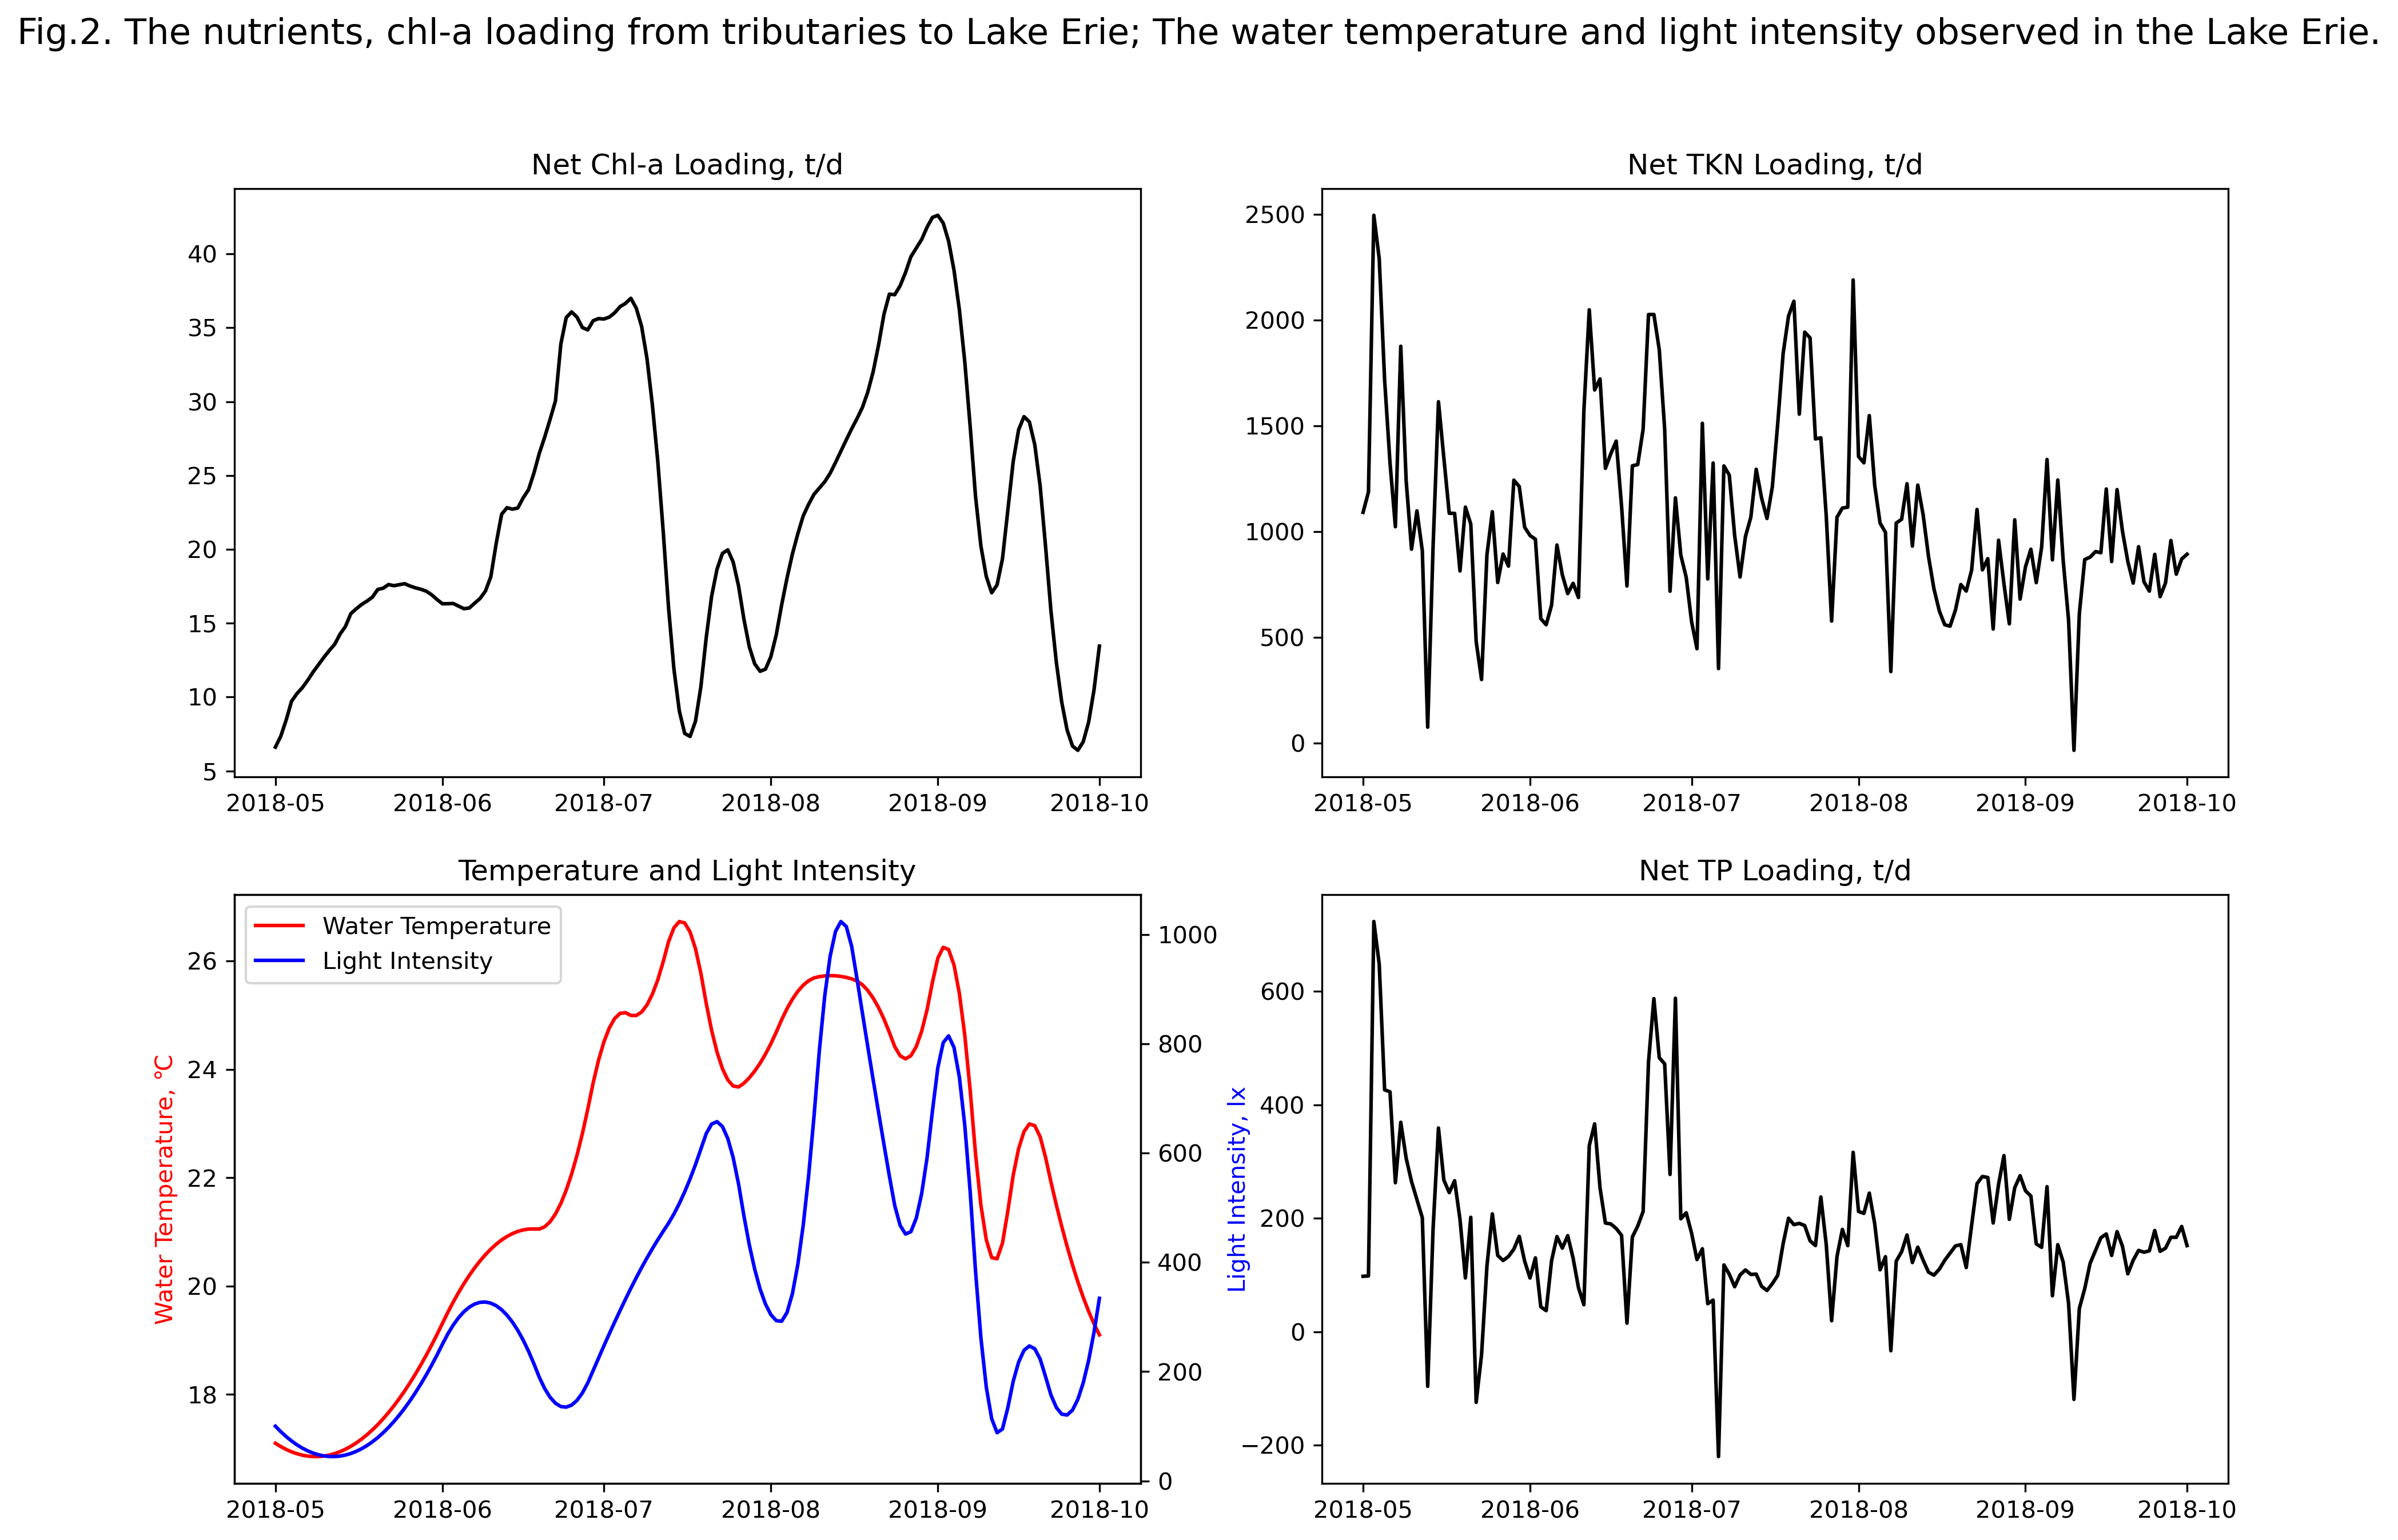

In [14]:
# Visualize the data
fig,axes = plt.subplots(2,2, figsize = (15,10), dpi = 300)
fig.suptitle('Fig.2. The nutrients, chl-a loading from tributaries to Lake Erie; The water temperature and light intensity observed in the Lake Erie.', fontsize = 15)
axes[0][0].plot(pd.date_range('2018-05-01','2018-10-01'), W_chla.values/1000000, color = 'black')
axes[0][0].set_title('Net Chl-a Loading, t/d')

axes[0][1].plot(pd.date_range('2018-05-01','2018-10-01'), W_tkn.values/1000000, color = 'black')
axes[0][1].set_title('Net TKN Loading, t/d')

axes[1][1].plot(pd.date_range('2018-05-01','2018-10-01'), W_tp.values/1000000, color = 'black')
axes[1][1].set_title('Net TP Loading, t/d')

l1 = axes[1][0].plot(pd.date_range('2018-05-01','2018-10-01'), WatTem, color = 'red')
axes[1][0].set_ylabel('Water Temperature, ℃',color = 'red')

ax = axes[1][0].twinx()
l2 = ax.plot(pd.date_range('2018-05-01','2018-10-01'), Light, color = 'blue')
ax.set_ylabel('Light Intensity, lx',color = 'blue')

axes[1][0].legend(l1+l2, ['Water Temperature','Light Intensity'])
axes[1][0].set_title('Temperature and Light Intensity')

## Model Results

The Model results were presented in Figure 3. The NSE of chl-a, TKN and TP model outputs were -4.44, -11.20 and -11.56 respectively. From the NSE perspective, the model performances were not good. However, when looking through the model output and observation results, we found the model can capture the peak events and showed a similar trend with the observations temporal variation. Take the chl-a result as an example, both the model and the observations increase from May 21st to June 12nd and successfully capture the peak value at June 15th. Between June 12nd and Sep 4th, both of them shared similar trend and the peak value of the model output (0.024 mg/L) was close the observed peak (0.029 mg/L).

Through checking the comparison plot, I found the chl-a modelling results were generally lower than the observed values, particularly during between June 12nd and Aug 6th. From the data credibility perspective, the validation data cannot represent the mean chl-a of the whole lake, because the sampling stations were located at western lake where algal biomass were significantly more than the other region as the MODIS image on Figure 1 shows. To take this factor into consideration, the model results may be close to the real mean chl-a concentration at Lake Erie.

But, from the model perspective. The deviation between the simulated and observed values of TKN and TP between June 12nd and Aug 6th was surprisingly opposite with that of chl-a. For instance, the modelling results of TKN were under 0.005mg/L but the observed results ranged from 0.10mg/L to 0.021mg/L. The situation was opposite when it comes to TKN and TP, the model outputs were significantly larger than the observed results. I assume that is because, the uptake process of TKN and TP during this period in the model was weakened. Thus, if we need to calibrate the model and make it closer to the reality, we can start with tunning the parameters related to the uptake processes, such as Upt_Nmax or Upt_Pmax.

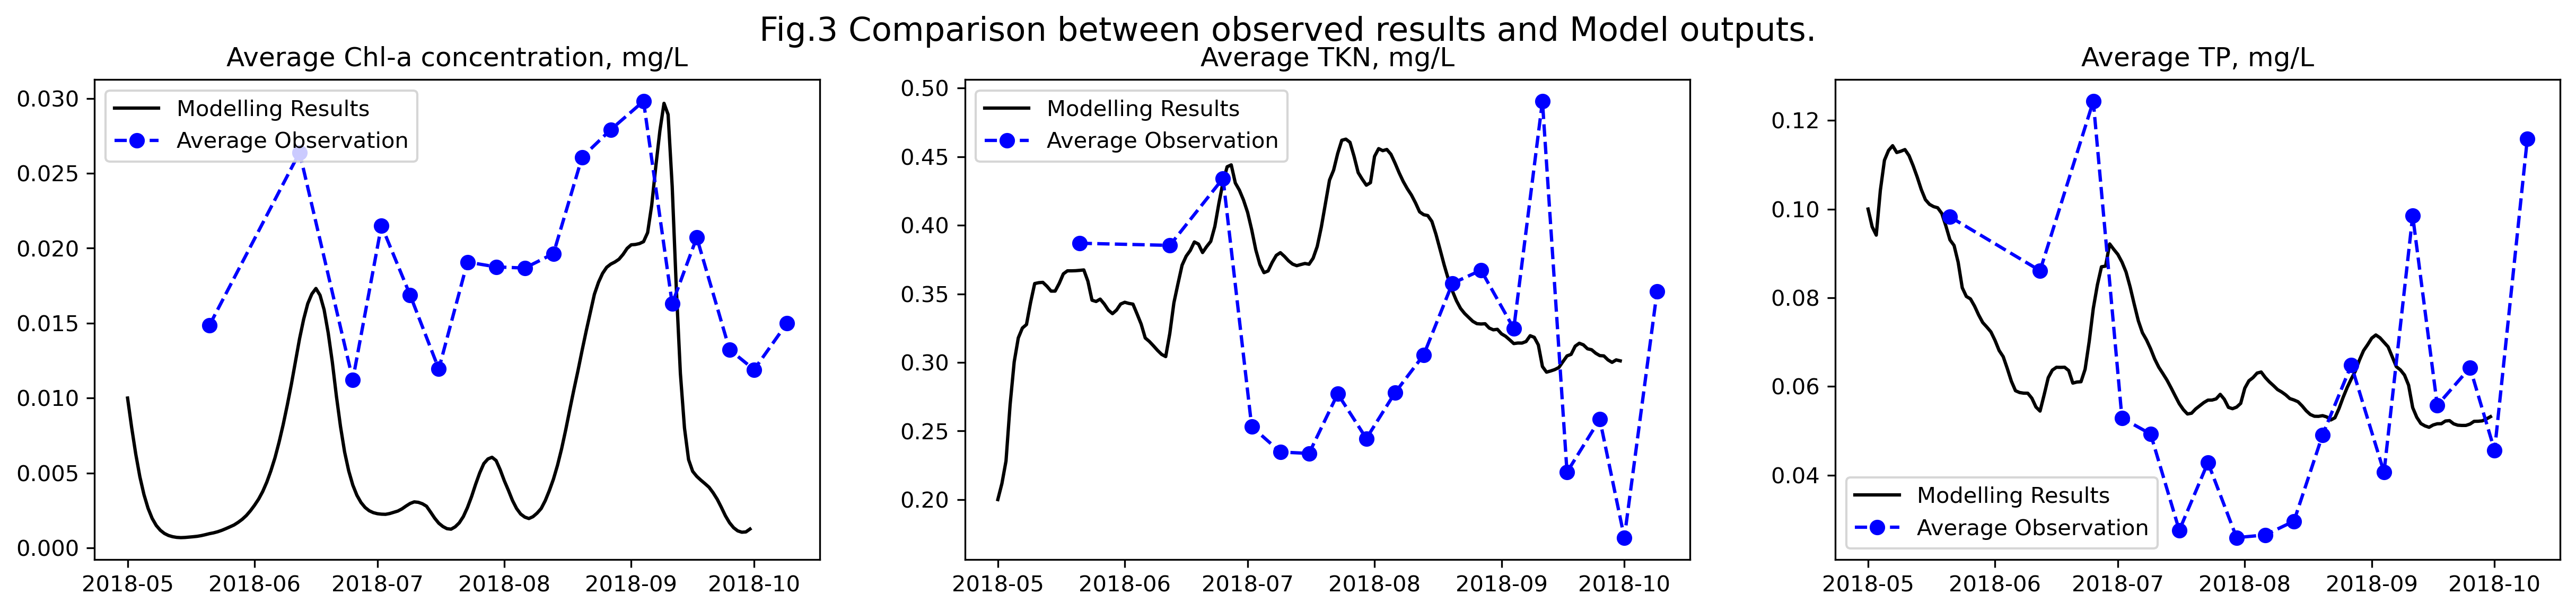

In [15]:
fig,axes = plt.subplots(1,3, figsize = (20,4), dpi = 300)
fig.suptitle('Fig.3 Comparison between observed results and Model outputs.', fontsize = 15)
# model results
chl_df = pd.DataFrame(chl, index = pd.date_range('2018-05-01', '2018-09-30'), columns=['chl-a, mg/L']).reindex(pd.date_range('2018-05-01', '2018-10-01'))
TN_df = pd.DataFrame(N, index = pd.date_range('2018-05-01', '2018-09-30'), columns=['TKN, mg/L']).reindex(pd.date_range('2018-05-01', '2018-10-01'))
TP_df = pd.DataFrame(P, index = pd.date_range('2018-05-01', '2018-09-30'), columns=['TP, mg/L']).reindex(pd.date_range('2018-05-01', '2018-10-01'))
# monitoring results
av_chla = lakewq.groupby(lakewq.index).mean()['chl-a']
av_tkn = lakewq.groupby(lakewq.index).mean()['TKN']
av_tp = lakewq.groupby(lakewq.index).mean()['TP']
axes[0].plot(pd.date_range('2018-05-01','2018-10-01'), chl_df.values, color = 'black' ,label = 'Modelling Results')
axes[0].plot(av_chla.index, av_chla.values/1000, 'bo--', label = 'Average Observation')
axes[0].set_title('Average Chl-a concentration, mg/L')
axes[0].legend()
axes[1].plot(pd.date_range('2018-05-01','2018-10-01'), TN_df.values, color = 'black' ,label = 'Modelling Results')
axes[1].plot(av_tkn.index, av_tkn.values,'bo--', label = 'Average Observation')
axes[1].set_title('Average TKN, mg/L')
axes[1].legend()
axes[2].plot(pd.date_range('2018-05-01','2018-10-01'), TP_df.values, color = 'black' ,label = 'Modelling Results')
axes[2].plot(av_tp.index, av_tp.values,'bo--' ,label = 'Average Observation')
axes[2].set_title('Average TP, mg/L')
axes[2].legend()

# Strategies improving model results

Apparently, the bias of the model was significant, but the model still showed the similar trend with the observed values and successfully captured the peak algal bloom in September. That means the model has potential to be a great tool to simulate algal bloom in lake ecosystem. To make it better, some thoughts were proposed below and welcome people who are interested in this model to continue.

To deal with the incredibility of the observed data, we can use the remote sensing technique to estimate the average chl-a concentration over the whole lake. Sensors like Sentinel-3 OLCI (Pinardi et al., 2015), MODIS Aqua(Shi et al., 2015), Landsat-8, etc. showed great performance detecting wide range of algal blooms. Applying the satellite derived data on both input (tributary loading) and output calibration and validation can significantly enhance the model accuracy.

Calibration is an important procedure for modelling. It is an optimization problem to get minimum Nash–Sutcliffe Efficiency coefficient by changing the combinations of parameters. The model is like a dominoes, slightly modification of a parameter would bring changes of many processes. Directly doing the Monte Carlo simulation on the 11 parameters are computationally exhausting. The first step is trying to find which process caused the most errors, then test the sensitivity of the parameters controlling the process(Jiang et al., 2018). Select 4 to 5 parameters then input them into a optimization function to get a best combination of parameters.

I've posted the model on my Github repository (https://github.com/he134543/XLake), welcome to download and apply the model on your studies. It would be appreciated that you can provide your thoughts on making the model better.

# Conclusion

An algal bloom model based on Python3 was developed to simulate the mean chl-a variation in a lake ecosystem. The model took the tributary loading, nutrient limitation, temperature and light effects on algal growth, uptake and death into consideration and quantified them with time based ordinary system equation systems. To test the mode ability, I built and validated the model with the nutrients, chl-a, hydrodynamic and meteorological data from the Lake Erie to simulate the chl-a variation in the algal bloom season in 2018 (May to Oct). The bias of the model was significant, but the model outputs showed a similar variation pattern with the trend of the observed results. To conclude, the model still as a large space to improve.

# Acknowledgments
The data in Lake Erie we used contained two parts: Tributary discharge and water quality data, physical parameters from the stations in the lake (water quality, water temperature, light intensity, water levels). The discharge of the of the main tributaries we used were from National water Inventory System (NWIS), maintained by U.S. Geological Survey (USGS). The water quality data of the tributaries were from the National Center for Water Quality Research, maintained by Heidelberg University. The monitoring data in the lake region were from the NOAA National Centers for Environmental Information, provided by Cooperative Institute for Great Lakes Research, University of Michigan and NOAA Great Lakes Environmental Research Laboratory. I sincerely thank Dr. Kostas Andreadis and all students in CEE-597J for creating such great environment to study water quality modelling.

# References
Chouvelon, T., Strady, E., Harmelin-Vivien, M., Radakovitch, O., Brach-Papa, C., Crochet, S., Knoery, J., Rozuel, E., Thomas, B., Tronczynski, J., Chiffoleau, J.-F., 2019. Patterns of trace metal bioaccumulation and trophic transfer in a phytoplankton-zooplankton-small pelagic fish marine food web. Marine Pollution Bulletin 146, 1013–1030. https://doi.org/https://doi.org/10.1016/j.marpolbul.2019.07.047

Glibert, P.M., Berdalet, E., Burford, M.A., Pitcher, G.C., Zhou, M., 2018. Introduction to the Global Ecology and Oceanography of Harmful Algal Blooms (GEOHAB) Synthesis, in: Glibert, P.M., Berdalet, E., Burford, M.A., Pitcher, G.C., Zhou, M. (Eds.), Global Ecology and Oceanography of Harmful Algal Blooms. Springer International Publishing, Cham, pp. 3–7. https://doi.org/10.1007/978-3-319-70069-4_1

He, X., Wang, H., Fan, L., Liang, D., Ao, Y., Zhuang, W., 2020. Quantifying physical transport and local proliferation of phytoplankton downstream of an eutrophicated lake. Journal of Hydrology 585, 124796. https://doi.org/10.1016/j.jhydrol.2020.124796

Huang, J., Xi, B., Xu, Q., Wang, X., Li, W., He, L., Liu, H., 2016. Experiment study of the effects of hydrodynamic disturbance on the interaction between the cyanobacterial growth and the nutrients. Journal of Hydrodynamics 28, 411–422.

Jiang, L., Li, Y., Zhao, X., Tillotson, M.R., Wang, W., Zhang, S., Sarpong, L., Asmaa, Q., Pan, B., 2018. Parameter uncertainty and sensitivity analysis of water quality model in Lake Taihu, China. Ecological Modelling 375, 1–12. https://doi.org/10.1016/j.ecolmodel.2018.02.014

Kim, J., Lee, T., Seo, D., 2017. Algal bloom prediction of the lower Han River, Korea using the EFDC hydrodynamic and water quality model. Ecological Modelling 366. https://doi.org/10.1016/j.ecolmodel.2017.10.015

Maccoux, M.J., Dove, A., Backus, S.M., Dolan, D.M., 2016. Total and soluble reactive phosphorus loadings to Lake Erie. Journal of Great Lakes Research 42. https://doi.org/10.1016/j.jglr.2016.08.005

McLean, T.I., Sinclair, G.A., 2012. Harmful Algal Blooms harmful algal bloom (HAB), in: Meyers, R.A. (Ed.), Encyclopedia of Sustainability Science and Technology. Springer New York, New York, NY, pp. 4819–4846. https://doi.org/10.1007/978-1-4419-0851-3_829

Paerl, H., 2017. The cyanobacterial nitrogen fixation paradox in natural waters. F1000research 6, 244.

Paul, V.J., 2008. Global warming and cyanobacterial harmful algal blooms, in: Hudnell, H.K. (Ed.), Cyanobacterial Harmful Algal Blooms: State of the Science and Research Needs. Springer New York, New York, NY, pp. 239–257. https://doi.org/10.1007/978-0-387-75865-7_11

Pinardi, M., Fenocchi, A., Giardino, C., Sibilla, S., Bartoli, M., Bresciani, M., 2015. Assessing Potential Algal Blooms in a Shallow Fluvial Lake by Combining Hydrodynamic Modelling and Remote-Sensed Images. Water 7, 1921–1942. https://doi.org/10.3390/w7051921

Shi, K., Zhang, Y., Xu, H., Zhu, G., Qin, B., Huang, C., Liu, X., Zhou, Y., Lv, H., 2015. Long-Term Satellite Observations of Microcystin Concentrations in Lake Taihu during Cyanobacterial Bloom Periods. Environmental Science & Technology 49, 6448–6456. https://doi.org/10.1021/es505901a

Steffen, M.M., Davis, T.W., Mckay, R.M., Bullerjahn, G.S., Krausfeldt, L.E., Stough, J.M.A., Neitzey, M.L., Gilbert, N.E., Boyer, G.L., Johengen, T.H., 2017. Ecophysiological examination of the Lake Erie Microcystis bloom in 2014: linkages between biology and the water supply shutdown of Toledo, Ohio. Environmental Science & Technology 51, acs.est.7b00856.

Tian-jiu, J., 2015. Effects of temperature,light intensity and nutrient condition on the growth and hemolytic activity of typical ichthyotoxic algae. Marine Environmental Science 34, 321–329.

Wang, H., Zhang, Z., Liang, D., Du, H., Pang, Y., Hu, K., Wang, J., 2016. Separation of wind’s influence on harmful cyanobacterial blooms. Water Research 98, 280–292. https://doi.org/10.1016/j.watres.2016.04.037